In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import nltk
from nltk import tokenize
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from string import punctuation
from razdel import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from natasha import MorphVocab, Doc, Segmenter, NewsEmbedding, NewsMorphTagger

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
df = pd.read_csv('e-catalog_phone_reviews.csv', index_col=0)

In [3]:
df

,review,type
0,Советую модель на 128 GB. Именно Pro в ней ест...,/img/svg/review-smile-4.svg
1,"Телефон - огонь) Хорошая модель, мне понравило...",/img/svg/review-smile-4.svg
2,"Аппарат очень хороший,конечно рекомендую к пре...",/img/svg/review-smile-4.svg
3,"Уверен, что телефон своих денег стои, а баланс...",/img/svg/review-smile-3.svg
4,"Всем рекомендую) Итак, искал я телефон для пок...",/img/svg/review-smile-4.svg
...,...,...
3685,"Не берите,за эти деньги можно найти и получше....",/img/svg/review-smile-1.svg
3686,модель с серьезными недостатками Тот телефон у...,/img/svg/review-smile-1.svg
3687,модель с серьезными недостатками Игры вылетают...,/img/svg/review-smile-1.svg
3688,"хорошая модель, понравилось У меня есть этот т...",/img/svg/review-smile-3.svg


## Преобразуем к двум типам

####  (/img/svg/review-smile-4.svg) --> 1

####  (/img/svg/review-smile-3.svg) --> 1

####  (/img/svg/review-smile-2.svg) --> 0

####  (/img/svg/review-smile-1.svg) --> 0

In [4]:
def convert_to_2_types(val):
    if val == '/img/svg/review-smile-4.svg':
        return 1
    elif val == '/img/svg/review-smile-3.svg':
        return 1
    elif val == '/img/svg/review-smile-2.svg':
        return 0
    elif val == '/img/svg/review-smile-1.svg':
        return 0

In [5]:
df['type'] = df['type'].apply(lambda x: convert_to_2_types(x))

In [6]:
df['type'].value_counts(normalize=True)

1    0.803145
0    0.196855
Name: type, dtype: float64

## Text Preprocessing

### Приведем к нижнему регистру

In [7]:
df['review'] = df['review'].str.lower()

### Уберем лишние символы

In [8]:
pat = r'[^0-9a-zA-zа-яёА-ЯЁ\-]'

def clean_str(val):
    
    val = re.sub(pat, ' ', val)
    
    val = val.replace(' -', ' ')
    val = val.replace('- ', ' ')
    val = val.replace(' - ', ' ')
    val = val.replace('  ', ' ')
    val = val.strip()
    
    return val

df['review'] = df['review'].apply(lambda x: clean_str(x))

### Токенизируем

In [9]:
df['review'] = df['review'].apply(lambda x: [y.text for y in tokenize(x)])

### Уберем стоп-слова и одиночные буквы

In [10]:
stop_words = stopwords.words('russian') + stopwords.words('english')

In [11]:
df['review'] = df['review'].apply(lambda x: [y for y in x if y not in stop_words and len(y) > 1])

### Лемматизация

In [12]:
morph_vocab = MorphVocab()
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
    
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text_list):
    doc = Doc(' '.join(text_list))
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    # лемматизация русских слов
    for token in doc.tokens:    
        token.lemmatize(morph_vocab)
    
    result = [x.lemma for x in doc.tokens]
    
    # лемматизация английских слов
    result = [lemmatizer.lemmatize(x) for x in result]

    return result

In [13]:
df['review'] = df['review'].apply(lambda x: lemmatize_text(x))

In [16]:
df['review'] = df['review'].apply(lambda x: ' '.join(x))

## CountVectorizer

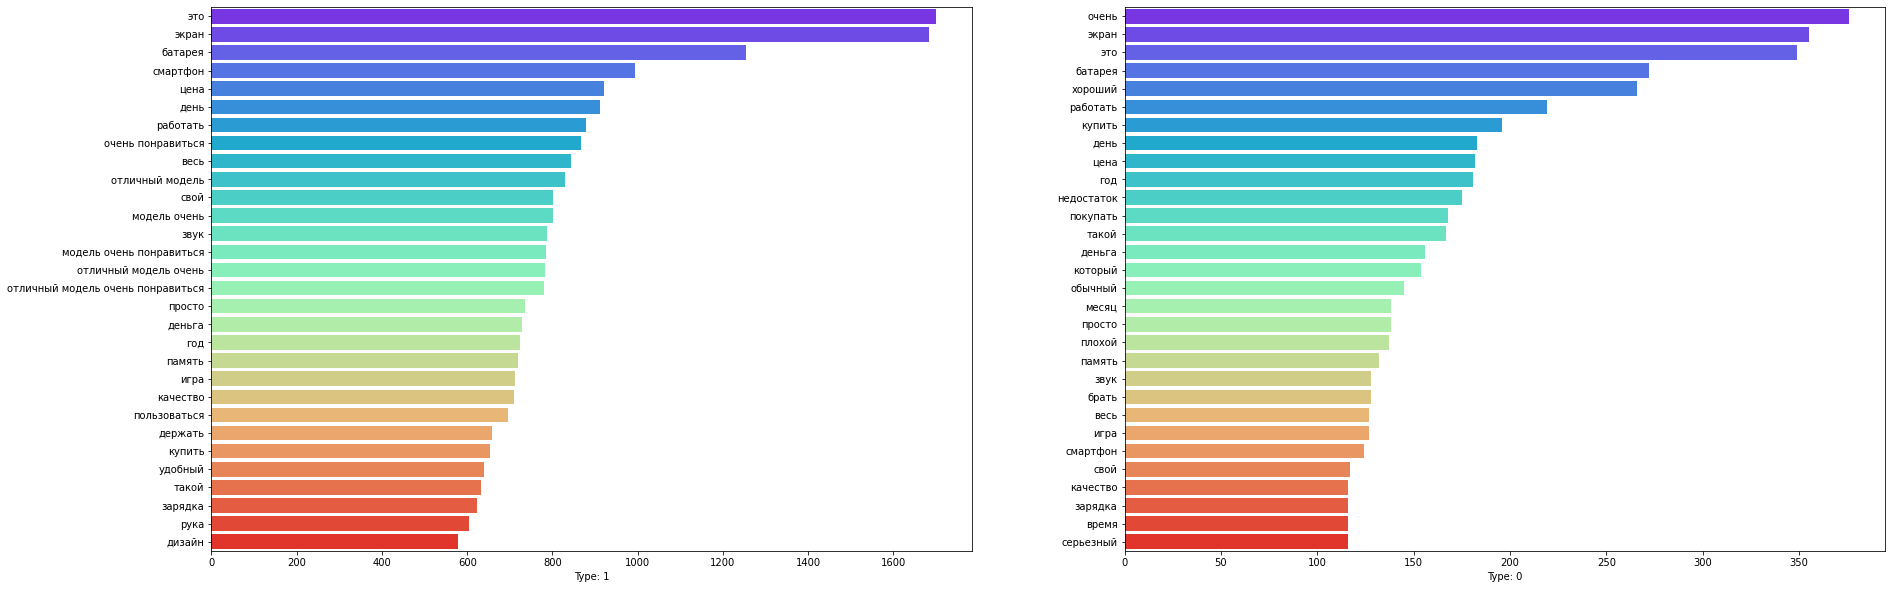

In [19]:
fig,ax = plt.subplots(1, 2, figsize=(30, 10))

i = 0

for review_type in df['type'].unique():
    vectorizer = CountVectorizer(max_df=0.4, min_df=0.01, ngram_range=(1, 4), max_features=1000)
    words = df.loc[df['type'] == review_type]['review'].to_list()
    vector = vectorizer.fit_transform(words)
    series = pd.DataFrame(data=vector.toarray(), 
                          columns=vectorizer.get_feature_names()).sum().sort_values(ascending=False)
    
    ax[i].set_xlabel(f'Type: {review_type}')
    sns.barplot(x=series.head(30), y=series.head(30).index, palette='rainbow', ax=ax[i])
    
    i += 1

## Splitting

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['type'], random_state=42, test_size=0.25)

## TF IDF

In [21]:
tf_idf_vec = TfidfVectorizer(max_df=0.4, min_df=0.01, ngram_range=(1, 4), max_features=1000, norm=False)

X_train_tf = tf_idf_vec.fit_transform(X_train)
X_train_tf = pd.DataFrame(data=X_train_tf.toarray(), columns=tf_idf_vec.get_feature_names())

X_test_tf = tf_idf_vec.transform(X_test)
X_test_tf = pd.DataFrame(data=X_test_tf.toarray(), columns=tf_idf_vec.get_feature_names())

In [22]:
print(len(X_train_tf), len(X_test_tf))

2766 922


## Plot Feature Importance

In [23]:
def plot_feature_impotance(feature_impotance_array):
    fig, ax = plt.subplots(1, 2, figsize=(25, 8))

    labels = ['Positive', 'Negative']

    featureImportance_positive = pd.DataFrame({"feature": X_train_tf.columns[feature_impotance_array != 0], 
                                      "importance": feature_impotance_array[feature_impotance_array!=0]}).sort_values(by='importance', ascending=False).head(25)

    featureImportance_negative = pd.DataFrame({"feature": X_train_tf.columns[feature_impotance_array != 0], 
                                      "importance": feature_impotance_array[feature_impotance_array!=0]}).sort_values(by='importance', ascending=True).head(25)

    sns.barplot(x='importance', y='feature', data=featureImportance_positive, ax=ax[1])
    sns.barplot(x='importance', y='feature', data=featureImportance_negative, ax=ax[0])

    ax[0].set_xlabel('Negative Sentiment')
    ax[0].set_ylabel(None)
    ax[1].set_xlabel('Positive Sentiment')
    ax[1].set_ylabel(None)

## Naive Bayes

In [24]:
mnnb = MultinomialNB()
mnnb.fit(X_train_tf, y_train)
preds = mnnb.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, preds)}')

              precision    recall  f1-score   support

           0     0.7360    0.7967    0.7652       182
           1     0.9490    0.9297    0.9392       740

    accuracy                         0.9035       922
   macro avg     0.8425    0.8632    0.8522       922
weighted avg     0.9069    0.9035    0.9049       922

ROC AUC score: 0.8632165132165133


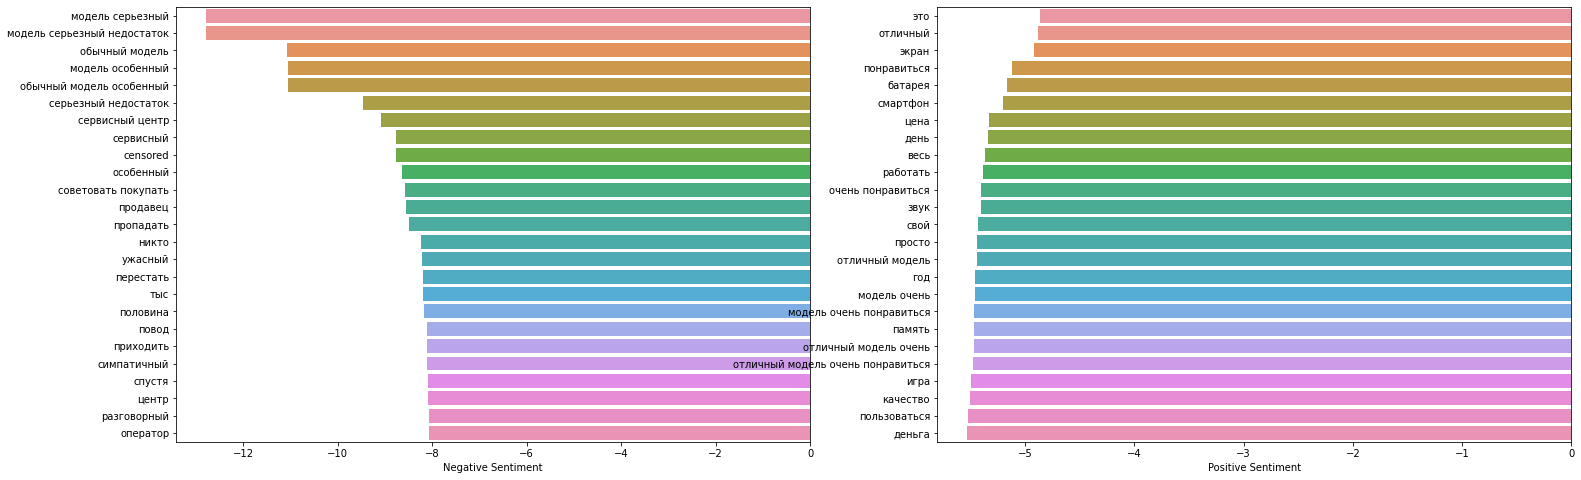

In [25]:
plot_feature_impotance(mnnb.coef_[0])

## Random Forest

In [26]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tf, y_train)
preds = rf.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, preds)}')

              precision    recall  f1-score   support

           0     0.9479    0.5000    0.6547       182
           1     0.8898    0.9932    0.9387       740

    accuracy                         0.8959       922
   macro avg     0.9189    0.7466    0.7967       922
weighted avg     0.9013    0.8959    0.8826       922

ROC AUC score: 0.7466216216216216


### SVM

In [27]:
svm = SVC(random_state=42)
svm.fit(X_train_tf, y_train)
preds = svm.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, preds)}')

              precision    recall  f1-score   support

           0     0.9859    0.3846    0.5534       182
           1     0.8684    0.9986    0.9290       740

    accuracy                         0.8774       922
   macro avg     0.9272    0.6916    0.7412       922
weighted avg     0.8916    0.8774    0.8548       922

ROC AUC score: 0.6916320166320167


## Logistic Regression

In [28]:
lr_no_reg = LogisticRegression(random_state=42, penalty='none')
lr_no_reg.fit(X_train_tf, y_train)
preds = lr_no_reg.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, preds)}')

              precision    recall  f1-score   support

           0     0.6853    0.7418    0.7124       182
           1     0.9352    0.9162    0.9256       740

    accuracy                         0.8818       922
   macro avg     0.8102    0.8290    0.8190       922
weighted avg     0.8858    0.8818    0.8835       922

ROC AUC score: 0.828987228987229


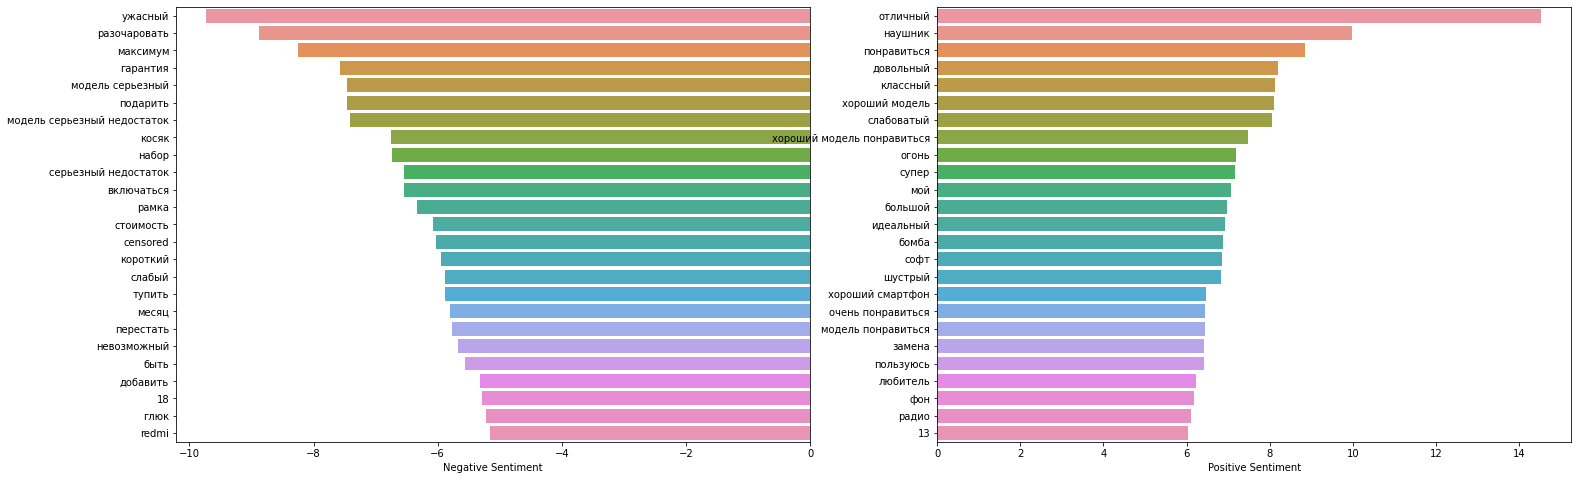

In [29]:
plot_feature_impotance(lr_no_reg.coef_[0])

In [34]:
lr_l2_reg = LogisticRegression(random_state=42, penalty='l2')
lr_l2_reg.fit(X_train_tf, y_train)
preds = lr_l2_reg.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, preds)}')

              precision    recall  f1-score   support

           0     0.6978    0.6978    0.6978       182
           1     0.9257    0.9257    0.9257       740

    accuracy                         0.8807       922
   macro avg     0.8117    0.8117    0.8117       922
weighted avg     0.8807    0.8807    0.8807       922

ROC AUC score: 0.8117389367389367


/home/kostya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


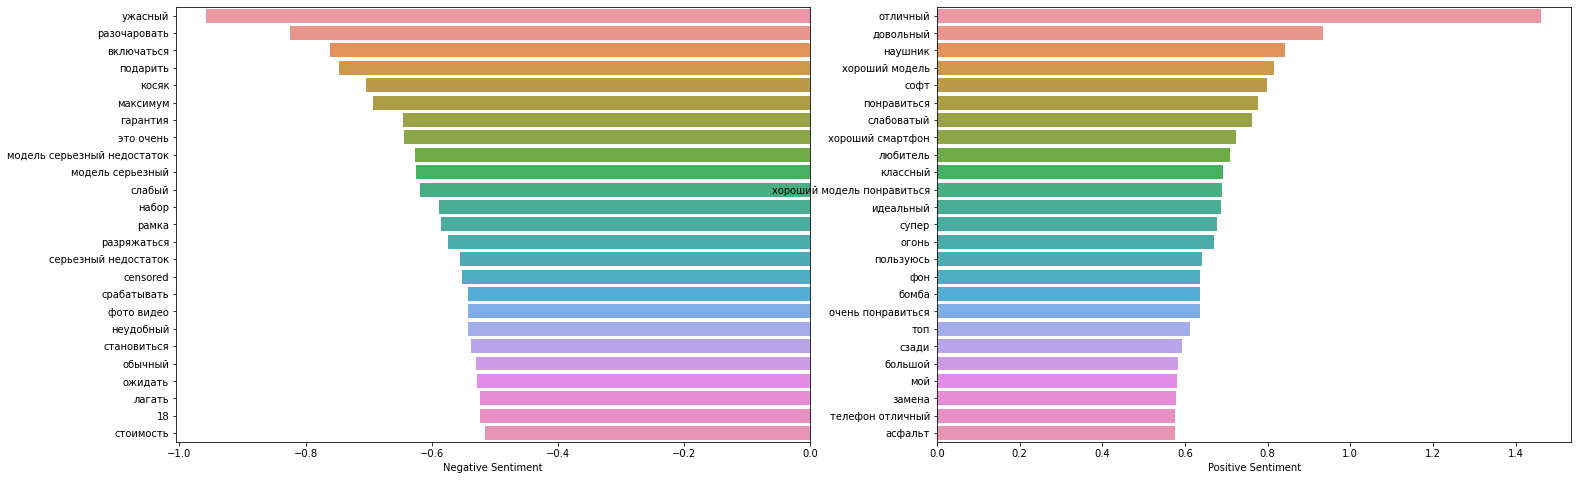

In [35]:
plot_feature_impotance(lr_l2_reg.coef_[0])

In [36]:
lr_l1_reg = LogisticRegression(random_state=42, penalty='l1', solver='liblinear')
lr_l1_reg.fit(X_train_tf, y_train)
preds = lr_l1_reg.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))
print(f'ROC AUC score: {roc_auc_score(y_test, preds)}')

              precision    recall  f1-score   support

           0     0.6995    0.7033    0.7014       182
           1     0.9269    0.9257    0.9263       740

    accuracy                         0.8818       922
   macro avg     0.8132    0.8145    0.8138       922
weighted avg     0.8820    0.8818    0.8819       922

ROC AUC score: 0.8144861894861894


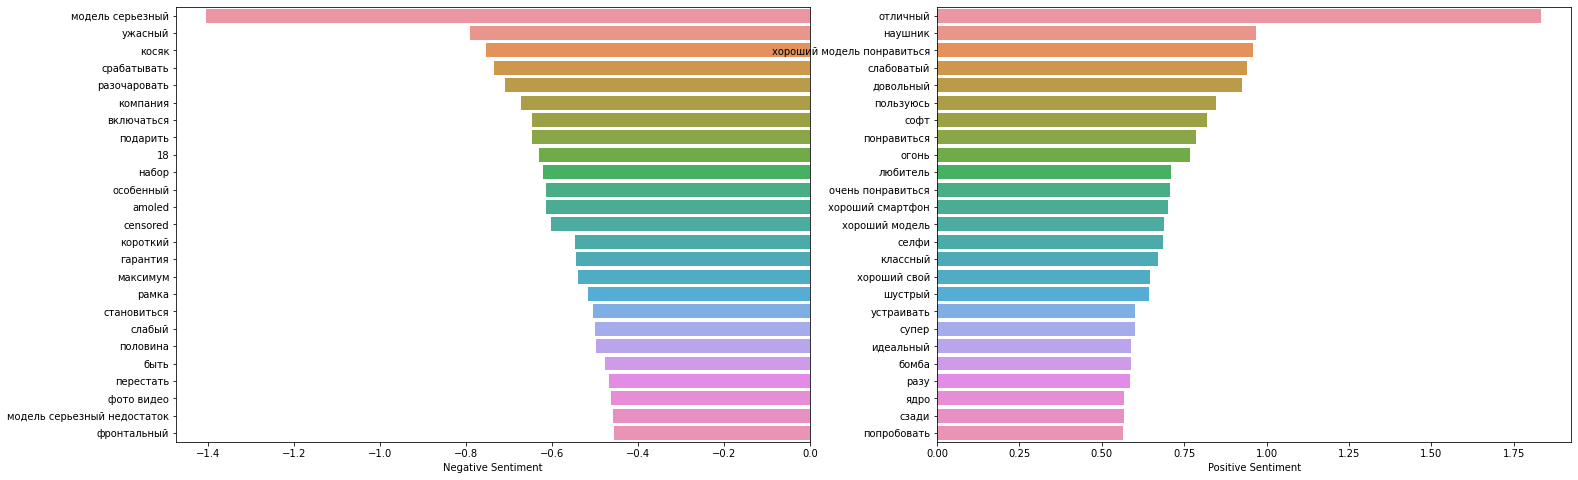

In [37]:
plot_feature_impotance(lr_l1_reg.coef_[0])